# Introdução à Ciência de Dados

## Projeto Final - Rentabilidade de IPO's Brasileiros

### Integrantes:
Davi Ribeiro Pereira Pinto - 20200023844

Gabriel Araújo de Azevedo Lima - 20200026120

Thalles Emannuel Batista Pinheiro - 20200025580


# 1 Introdução

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib import cm
import numpy as np
from scipy.stats import linregress
from IPython.display import clear_output

In [2]:
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

## 1.1 Motivação

O que são IPO's
Quais operações são feitas: Flippagem
Aumento significativo da quantidade nos anos passados




In [3]:
investidores = pd.read_excel("./datasets/Investidores.xlsx")
investidores = investidores.melt(id_vars='Ano', value_vars=['Homens', 'Mulheres']).rename(columns={"variable": 'Genero', 
                                                                                                   "value": 'Quantidade'})
investidores['Quantidade'] /= 1000000 
investidores.head()

,Ano,Genero,Quantidade
0,2021,Homens,2.707331
1,2020,Homens,2.382966
2,2019,Homens,1.277424
3,2018,Homens,0.634269
4,2017,Homens,0.478258


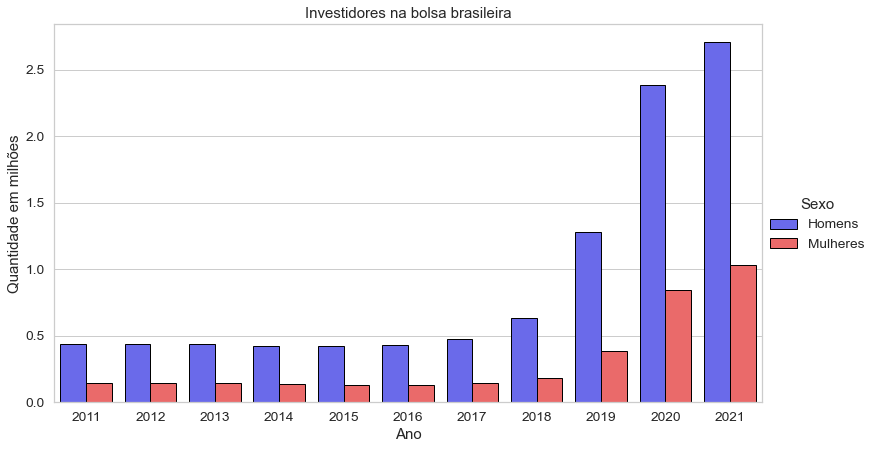

In [4]:
def plot_investidores(data):
    sns.set(font_scale = 1.25, style="whitegrid")
    g = sns.catplot(data=data, x="Ano", y="Quantidade", hue="Genero",
                    height=6, aspect=16/9, kind="bar", palette='seismic', ec = 'black')
    
    plt.title('Investidores na bolsa brasileira')
    g.despine(left=False, right=False, top=False)
    g.set_axis_labels("Ano", "Quantidade em milhões")
    g.legend.set_title("Sexo")
    plt.show()

plot_investidores(investidores)

## 1.2 Objetivos

1 - Calcular as rentabilidades médias dos IPO's realizados e buscar correlações para realizar entradas nos possíveis melhores IPOs futuros.

# 2 Dados utilizados

Para realizar deste trabalho foram extraídos da B3 as cotações históricas das ações negociadas bem como o relatorio das ofertas públicas relaizadas.  

Todos os dados utilizados estão disponível no [Github](https://github.com/davirpp/Projeto_Intro_CD/tree/master/datasets).

In [5]:
ipo_df = pd.read_csv("./datasets/COTAHIST_A2015_2021.csv")
ipo_details = pd.read_excel("./datasets/IPO_details.xlsx")
cota_ibov = pd.read_csv("./datasets/COTAHIST_IBOV.csv")
covid_df = pd.read_csv("./datasets/covid.csv")

## 2.1 Cotações históricas

Os dados utilizados foram as cotações históricas retiradas do site oficial da [B3](http://www.b3.com.br/pt_br/market-data-e-indices/servicos-de-dados/market-data/historico/mercado-a-vista/series-historicas/).

## 2.2 Cotação Índice Ibovespa
Os dados utilizados foram retirados do site da [Investing](https://br.investing.com/indices/bovespa-historical-data) as cotações diárias do Índice Ibovespa do dia 05/06/2015 até 09/06/2021 (data que compreende nossos dados).

## 2.3 Ofertas públicas

Foram retirados dados detalhados das Ofertas Públicas do site da [B3](http://www.b3.com.br/pt_br/produtos-e-servicos/solucoes-para-emissores/ofertas-publicas/estatisticas/).

# 3 Pré-processamento

## 3.1 Cotações Históricas

Nas células abaixos ocorre o pré-processamento dos dados conforme instruções contidas no layout adotado pela B3.
Que pode ser visto em: [Layout](http://www.b3.com.br/data/files/33/67/B9/50/D84057102C784E47AC094EA8/SeriesHistoricas_Layout.pdf).

In [6]:
def create_csv_b3():
    year_i = int(input('Insira o ano de início: '))
    year_f = int(input('Insira o ano de término: '))
    years = list(range(year_i,year_f+1))

    list_ipos = ["PARC3", "WIZS3", "AALR3",
                 "MOVI3", "PARD3", "AZUL4", "CRFB3", "IRBR3", "OMGE3", "CAML3", "BKBR3", "BRDT3",
                 "GNDI3", "HAPV3", "BIDI4",
                 "SBFG3", "CNTO3","NEOE3", "VIVA3", "BMGB4", "CEAB3", 
                 "MTRE3", "LWSA3", "MDNE3", "PRNR3", "ALPK3", "AMBP3", "SOMA3", "DMVF3", "LJQQ3", "LAVV3", "PGMN3",
                 "PETZ3", "PLPL3", "MELK3", "HBSA3", "CURY3", "BOAS3", "SEQL3", "GMAT3", "TFCO4", "CASH3", "ENJU3", 
                 "AERI3", "RRRP3", "AVLL3", "RDOR3", "NGRD3", "HBRE3", "VAMO3", "ESPA3", "INTB3", "MOSI3", "MBLY3", 
                 "JALL3", "POWE3", "CSED3", "OPCT3", "ORVR3", "ELMD3", "BMOB3", "CMIN3", "WEST3", "MODL11", "MATD3", 
                 "BLAU3", "GGPS3", "SOJA3", "RECV3", "CXSE3", "ALLD3"]

    def b3_parser(year):
        cota = open(f"./datasets/datab3/COTAHIST_A{year}.txt",'r')
        head = cota.readline()
        line = cota.readline()
        all_data = []
        size = [2, 8, 2, 12, 3, 12, 10, 3, 4, 13, 13, 13, 13, 13, 13, 13, 5, 18, 18, 13, 1, 8, 7, 13, 12, 3]
        col = ['tipreg', 'date', 'codbdi', 'codneg', 'tpmerc', 'nomres', 'especi', 'prazot', 'modref', 'preabe', 
               'premax', 'premin', 'premed', 'preult', 'preofc', 'preofv', 'totneg', 'quatot', 'voltot', 'preexe', 
               'indopc', 'datven', 'fatcot', 'ptoexe', 'codisi', 'dismes']
        #OBS.: The name of the columns is a pattern adopted by B3

        while line:
            dt = []
            x = 0
            for s in size: 
                dt.append(line[x:x+s]) 
                x+=s 
            all_data.append(dt)
            line = cota.readline()
            if line.startswith('99'): 
                break

        df = pd.DataFrame(data=all_data,columns=col)
        col = ['tipreg',  'codbdi',  'tpmerc', 'totneg', 'quatot', 'indopc', 'datven', 'fatcot',  'dismes']
        for c in col:
            df[c]=pd.to_numeric(df[c], downcast="integer")

        col = ['preabe', 'premax', 'premin', 'premed', 'preult', 'preofc', 'preofv','voltot', 'preexe','ptoexe']
        for c in col:
            df[c] = df[c].astype(float)/100

        col = ['date','datven']
        for c in col:
            df[c] = pd.to_datetime(df[c],format='%Y%m%d',errors='coerce')

        col = ['codneg']
        for c in col:
            df[c] = df[c].str.strip()

        return df

    def listFilter(dataframe, valores):
        return dataframe.loc[dataframe['codneg'].isin(valores)]

    df_list = []
    for year in years:
        df = b3_parser(year)
        df = listFilter(df, list_ipos)

        # CELL TO CHOOSE DESIRABLE COLUMNS
        df = df[['date','codneg','preabe','preult']]

        # RESETING INDEX
        df = df.reset_index(drop=True)

        # TRANSFORMING THE DATAFRAME IN CSV BY YEARS
        df.to_csv(f"COTAHIST_A{year}.csv", index = False)

        df_list.append(df)

    df = pd.read_csv(f"./COTAHIST_A{year_i}.csv")
    for year in range(year_i+1, year_f+1):
        df = pd.concat([df, pd.read_csv(f"./COTAHIST_A{year}.csv")])

    df.loc[df.codneg=='PARC3', 'codneg'] = 'WIZS3'
    df.loc[df.codneg=='CNTO3', 'codneg'] = 'SBFG3'

    # RESETING INDEX
    df = df.reset_index(drop=True)

    # TRANSFORMING THE DATAFRAME IN CSV OF ALL YEARS
    df.to_csv(f"COTAHIST_A{year_i}_{year_f}.csv", index = False)

In [7]:
#create_csv_b3()

## 3.3 Cotações Históricas Ajustadas - Yahoo Finance

In [8]:
import pandas_datareader.data as web
#Caso não tiver a biblioteca Yahoo Finance, tire a '#' da linha abaixo.
#!pip install yfinance --upgrade --no-cache-dir
import yfinance as yf
yf.pdr_override()
clear_output(wait=True)

In [9]:
tickers = list(ipo_details.Tickers)
openings = list(ipo_details.Preco_fixado)
dict_tickers = dict(zip(tickers, openings))

In [10]:
date_list = []
for ticker in tickers:
    df = ipo_df[ipo_df.codneg==ticker]
    df.sort_values(by='date')
    date_list.append(df["date"].iloc[0])
    
date_ipo_df = pd.DataFrame(list(zip(tickers, date_list)), columns=["tickers", "date"])
date_ipo_df["date"] = pd.to_datetime(date_ipo_df["date"], format='%Y-%m-%d')
date_ipo_df['year'] = date_ipo_df.apply(lambda x: x.date.year,axis=1)
date_ipo_df['month'] = date_ipo_df.apply(lambda x: x.date.month,axis=1)

In [11]:
date_ipo_dict = dict(zip(tickers, list(date_ipo_df['date']) ))
historico_dict = {}

for ticker in tickers:
    clear_output(wait=True)
    y_ticker = f'{ticker}.SA'
    historico = web.get_data_yahoo(y_ticker)
    historico = historico.reset_index(drop=False)[['Date','Adj Close']]
    historico.insert(1,'Ticker',0)
    historico['Ticker'] = historico.apply(lambda x: ticker,axis=1)
    historico = historico[historico.Date >= date_ipo_dict[ticker] ]
    historico_dict[ticker] = historico


hist = historico_dict['WIZS3']
for ticker in historico_dict:
    if ticker == 'WIZS3':
       continue
    hist = pd.concat([hist,historico_dict[ticker]])

hist = hist.sort_values('Date')
hist = hist.reset_index(drop=True)

[*********************100%***********************]  1 of 1 completed


## 3.3 Cotação Índice Ibovespa 

In [12]:
def create_ibov():
    cota_ibov = pd.read_csv("./datasets/Cota_ibov.csv")
    def format_number(texto):    
        return float(texto.replace('.', '').replace(',', '.'))

    def format_percent(texto):   
        return float(texto.replace(',', '.').replace('%', ''))

    cota_ibov['Último'] = cota_ibov.apply(lambda x: format_number(x['Último']), axis=1)
    cota_ibov['Var%'] = cota_ibov.apply(lambda x: format_percent(x['Var%']), axis=1)

    ibov = cota_ibov[['Data', 'Último', 'Var%']].copy()

    ibov['Data'] = ibov.apply(lambda x: pd.to_datetime(x['Data'],format='%d.%m.%Y',errors='coerce'), axis=1)
    ibov = ibov.sort_values(by='Data', ascending = True)
    ibov = ibov.reset_index(drop=True)

    #Creating a column to calculate the acumulated rentability
    ibov['Cumulative'] = 0

    for i in range((ibov.index.max()) + 1):
        ibov.loc[i,'Cumulative'] = (((ibov.loc[i, 'Último'] / ibov.loc[0, 'Último']) - 1) * 100)

    # TRANSFORMING THE DATAFRAME IN CSV 
    ibov.to_csv(f"COTAHIST_IBOV.csv", index = False)

In [13]:
#create_ibov()

# 4 Perguntas

## 4.1 Quantos IPO's foram realizados de 2015 à Maio de 2021?

In [14]:
#serie pandas dos anos:

ipos_per_year = date_ipo_df.groupby('year').count()
ipos_per_year = ipos_per_year.reset_index(drop=False)[['year','tickers']]
ipos_per_year = ipos_per_year.rename(columns={'year':'Ano', 'tickers':'Quantidade'})
ipos_per_year.Ano = ipos_per_year.apply(lambda x: str(x.Ano), axis = 1)

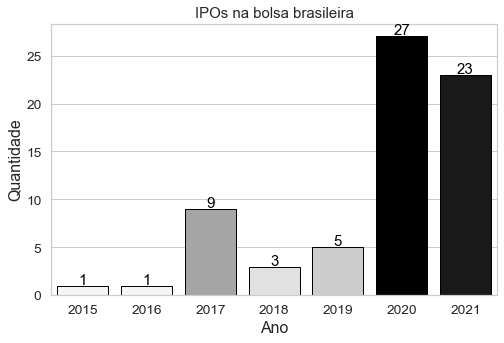

In [15]:
def plot_quantidade_ipos(data):
    ipos_per_year = data
    sns.set(rc={'figure.figsize':(8,5)}, font_scale = 1.25, style='whitegrid')
    # sns.set(font_scale = 1.25)
    # sns.set_style('whitegrid')
    quant_year_b = sns.barplot(x='Ano', y='Quantidade', data=ipos_per_year, 
                               palette= cm.gist_yarg(ipos_per_year['Quantidade']*10),
                               ec= 'black')
    quant_year_b.set_xlabel('Ano', fontsize = 16)
    quant_year_b.set_ylabel('Quantidade', fontsize = 16)
    for index, row in ipos_per_year.iterrows():
        quant_year_b.text(row.name, row.Quantidade+0.175, round(row.Quantidade,2), color="black", ha="center")
      
    plt.title('IPOs na bolsa brasileira')
    plt.show()

plot_quantidade_ipos(ipos_per_year)

## 4.2 Qual a rentabilidade dos IPOs considerando vendas dos ativos a curto, médio e longo prazo?

In [16]:
def rentability(ticker, dias_uteis, dict_ticker=dict_tickers, data=ipo_df):
    ticker = ticker.upper()
    df = data[data.codneg==ticker]
    df = df.reset_index(drop=True)
    variation = ((df["preult"].iloc[dias_uteis-1]/dict_ticker[ticker])-1)*100
    return variation

In [17]:
ipos_dict = {}
for i in range(2015,2022):
    ipos_dict[i] = date_ipo_df[(date_ipo_df['date'] >= f'{i}-01-01') & (date_ipo_df['date'] <= f'{i}-12-31')]

In [18]:
rent_df_dict = {}
for year in range(2015,2022):
    columns=["1D", "1M", "3M", "6M"]
    rent_df_dict[year] = pd.DataFrame(columns=columns)
    time = [1, 20, 60, 120]
    tickers_temp = ipos_dict[year]["tickers"]
    for t in tickers_temp:
        lista = []
        for i in time:
            try:
                lista.append(rentability(t, i))
            except:
                lista.append(np.nan)
        rent_df_dict[year].loc[t] = lista
    rent_df_dict[year]['year'] = year

### 2015 a 2021

In [19]:
rent_df = pd.DataFrame(columns=["1D", "15D"])
time = [1, 10]
for t in tickers:
    rent_df.loc[t] = [rentability(t, c) for c in time]
rent_df.describe()

,1D,15D
count,69.000000,69.000000
mean,5.995371,5.621224
std,16.192957,17.366194
min,-27.586207,-27.764706
25%,-1.851852,-6.470588
50%,0.458333,4.216867
75%,8.947368,14.500000
max,96.969697,57.777778


In [20]:
def average_rentability_lineplot():
    total_average_dict = {}
    for c in ["1D", "1M", "3M", "6M"]:
        void_dict = {}
        for ano in range(2015, 2022):
            try:
                void_dict[ano] = [rent_df_dict[ano][c].mean(), rent_df_dict[ano][c].std()]
            except:
                void_dict[ano] = np.nan
        total_average_dict[c] = void_dict 
    return total_average_dict

In [21]:
average_lineplot = average_rentability_lineplot()

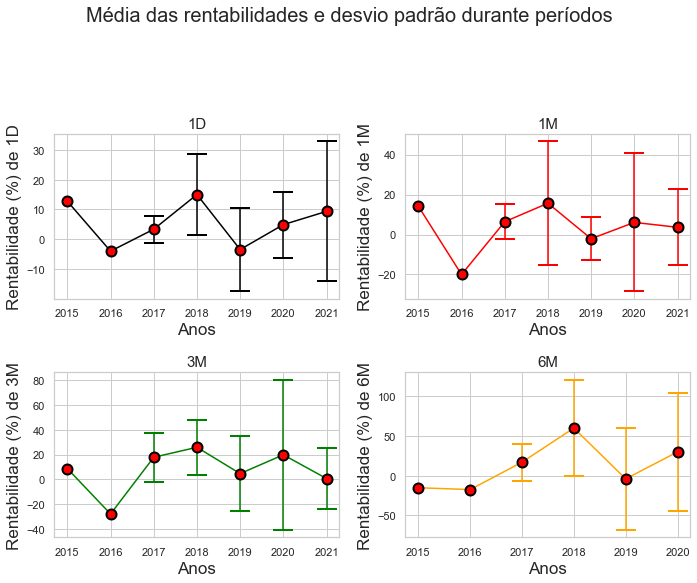

In [22]:
def plot_errobar(average_lineplot):
    sns.set(rc={'figure.figsize':(10,8)})
    sns.set_style('whitegrid')

    colors = {'1D':'black','1M':'red','3M':'green','6M':'orange'}
    fig, axs = plt.subplots(2, 2)
    #fig.title('Title', pad=20)
    fig.suptitle('Média das rentabilidades e desvio padrão durante períodos\n\n', y=1.02, fontsize=20)

    for i,c in enumerate(['1D','1M','3M','6M']):
        df = pd.DataFrame(average_lineplot[c]).T
        x = np.array(df.index)
        y = np.array(df[0])
        erro = np.array(df[1])

        if i == 0 or i == 1:
            axs[0,i].errorbar(x,y,yerr=erro, 
                              color = colors[c], ls = '-', # cor e tipo da linha
                              fmt = 'o', mfc = 'red', mec = 'black',
                              mew = 2, ms = 10, 
                              ecolor = colors[c],
                              capsize = 10)

            axs[0,i].set_title(c, fontsize=15)
            axs[0,i].set_xlabel('Anos', fontsize = 17)
            axs[0,i].set_ylabel(f'Rentabilidade (%) de {c}', fontsize = 17)

        else:
            axs[1,i-2].errorbar(x,y,yerr=erro, 
                                color = colors[c], ls = '-', # cor e tipo da linha
                                fmt = 'o', mfc = 'red', mec = 'black',
                                mew = 2, ms = 10, 
                                ecolor = colors[c],
                                capsize = 10)

            axs[1,i-2].set_title(c, fontsize=15)

            axs[1,i-2].set_xlabel('Anos', fontsize = 17)
            axs[1,i-2].set_ylabel(f'Rentabilidade (%) de {c}', fontsize = 17)

        # plt.xlim([0,125])
        # plt.ylim([0,125])

    fig.tight_layout(pad=1.5)

plot_errobar(average_lineplot)

ValueError: Could not interpret input 'variable'

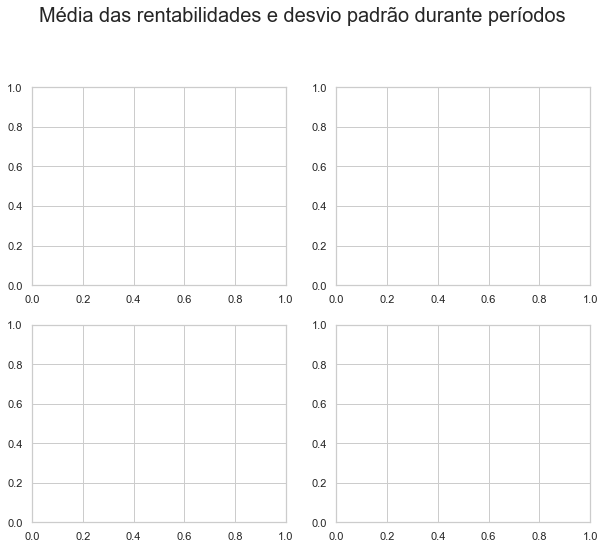

In [23]:
sns.set(rc={'figure.figsize':(10,8)}, style='whitegrid')
colors = {'1D':'black','1M':'red','3M':'green','6M':'orange'}
fig, axs = plt.subplots(2, 2)
#fig.title('Title', pad=20)
fig.suptitle('Média das rentabilidades e desvio padrão durante períodos\n\n', y=1.02, fontsize=20)
sns.boxplot(ax = axs[0,0], data=rent_df_dict[2018], x="variable", y='value')

# rent_df_dict[2018].boxplot(column=["1D", "1M", "3M", "6M"])

In [24]:
def average_rentability_barplot():
    total_average_dict = {}
    for c in ["1D", "1M", "3M", "6M"]:
        void_dict = {}
        auxiliar = 0
        for ano in range(2015, 2022):
            try:
                x = rent_df_dict[ano][c].mean() + auxiliar
                void_dict[ano] = [rent_df_dict[ano][c].mean(), rent_df_dict[ano][c].std(), x]
                auxiliar = x
            except:
                void_dict[ano] = np.nan
        total_average_dict[c] = void_dict    
    return total_average_dict

In [25]:
average_barplot = average_rentability_barplot()

In [35]:
average_barplot_1d = pd.DataFrame(average_barplot["1D"]).T.reset_index().rename(columns = {"index": "Ano", 0: "Media", 1: "Desvio", 2: "Acumulada"})
average_barplot_1m = pd.DataFrame(average_barplot["1M"]).T.reset_index().rename(columns = {"index": "Ano", 0: "Media", 1: "Desvio", 2: "Acumulada"})
average_barplot_3m = pd.DataFrame(average_barplot["3M"]).T.reset_index().rename(columns = {"index": "Ano", 0: "Media", 1: "Desvio", 2: "Acumulada"})
average_barplot_6m = pd.DataFrame(average_barplot["6M"]).T.reset_index().rename(columns = {"index": "Ano", 0: "Media", 1: "Desvio", 2: "Acumulada"})

In [36]:
average_barplot_6m = average_barplot_6m[0:6]

In [46]:
def plot_average_barplot(df, periodo):
    df = df.copy()
    df['m_plot'] = df.Media
    df.loc[0,'m_plot'] = np.nan
    df['m_pos'] = df.apply(lambda x: x.Media if x.Media > 0 else np.nan, axis = 1)
    df['m_neg'] = df.apply(lambda x: x.Media if x.Media < 0 else np.nan, axis = 1)    
    sns.set(rc={'figure.figsize':(8,5)}, font_scale = 1.25, style='whitegrid')
    list_media = list(df["Media"])
    list_acumulada = list(df["Acumulada"]) + list_media    
    plt.ylim([round(min(list_acumulada) - 5), round(max(list_acumulada) + 5)])
    axes = sns.lineplot(data = df["Acumulada"], marker='o', sort = False, color ='Red')
    axes2 = sns.barplot(data = df, x='Ano', y="Media", palette=cm.gist_yarg(df['Media']*10), alpha=0.9, ec= 'black')
    plt.suptitle(f"Rentabilidades com venda em {periodo}",y=0.98)
    plt.legend(labels=["Rentabilidade acumulada"])
    plt.ylabel('Média (%)')
    for index, row in df.iterrows():   
        #axes.text(row.name, row.Media, round(row.Media,2), color="black", ha="center")
        #axes.text(row.name, row.m_pos//2,/ round(row.m_pos,2), color="white", ha="center")
        #axes.text(row.name, row.m_neg//(3/2), round(row.m_neg,2), color="black", ha="center")
        axes2.text(row.name, row.Acumulada+2.1, round(row.Acumulada,2), color="black", bbox=dict(facecolor='white', alpha=0.5), ha="center")
    
    # clear_output(wait=True)

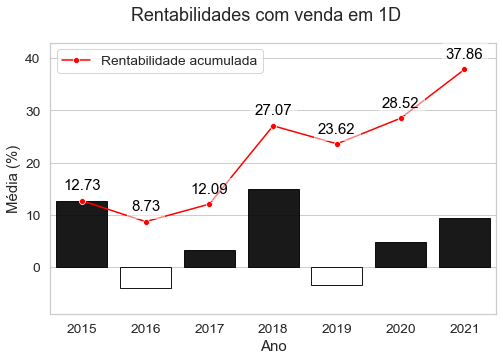

In [47]:
plot_average_barplot(average_barplot_1d,'1D')

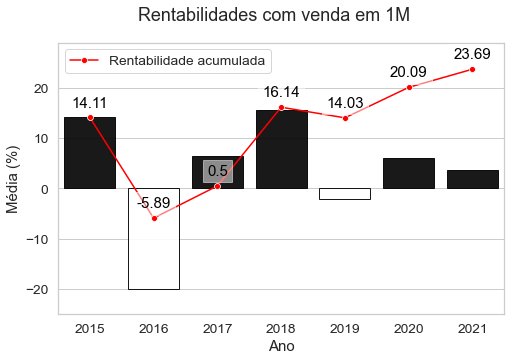

In [48]:
plot_average_barplot(average_barplot_1m,'1M')

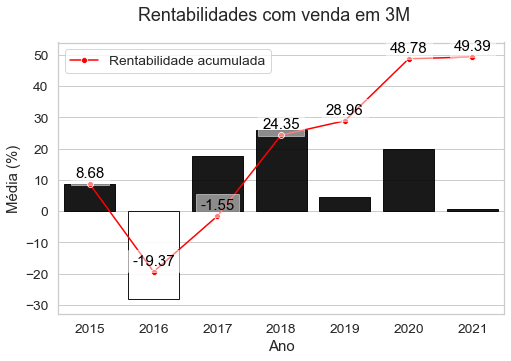

In [49]:
plot_average_barplot(average_barplot_3m,'3M')

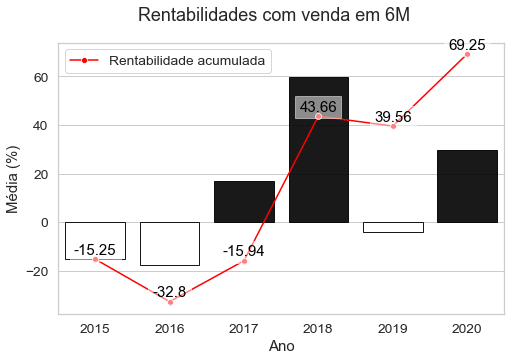

In [50]:
plot_average_barplot(average_barplot_6m,'6M')

In [38]:
list_rent_1d = []
for t in tickers:
    list_rent_1d.append(rentability(t, 1))
dict_rent_1d = dict(zip(tickers,list_rent_1d))

df_rent = pd.DataFrame.from_dict(dict_rent_1d, orient='index').rename(columns={0:'Rentabilidade_1D'})
df_rent = df_rent.reset_index().rename(columns={'index':'Ticker'})
df_rent = df_rent.sort_values("Rentabilidade_1D", ascending = False).reset_index(drop=True)

menor_m15 = entremenos15_e_menos10 = entremenos10_e_men5 = entremen5_e_0 = 0
entre0_e_5 = entre5_e_10 = entre10_e_15 = maior_15 = 0
for i in range(df_rent.index.max() + 1):
    x = df_rent.loc[i, 'Rentabilidade_1D']
    if x < -15:
        menor_m15 += 1
    elif( -15 <= x < -10): 
        entremenos15_e_menos10 += 1
    elif( -10 <= x < -5): 
        entremenos10_e_men5 += 1
    elif(-5 <= x <0):
        entremen5_e_0 += 1 
    elif(0 <= x < 5):
        entre0_e_5 += 1 
    elif(5 <= x < 10):
        entre5_e_10 += 1         
    elif(10 <= x < 15):
        entre10_e_15 += 1 
    elif(15 < x):
        maior_15 += 1

df = pd.DataFrame({'<-15%': menor_m15, '-15% a -10%': entremenos15_e_menos10, '-10% a -5%': entremenos10_e_men5, 
                   '-5% a 0%': entremen5_e_0, '0% a 5%': entre0_e_5, '5% a 10%': entre5_e_10, 
                   '10% a 15%': entre10_e_15, '>15%': maior_15}, index = [0])
DF = df.T
DF = DF.reset_index().rename(columns={'index':'Valor', 0: 'Quantidade'})
DF

,Valor,Quantidade
0,<-15%,1
1,-15% a -10%,1
2,-10% a -5%,7
3,-5% a 0%,20
4,0% a 5%,11
5,5% a 10%,12
6,10% a 15%,2
7,>15%,15


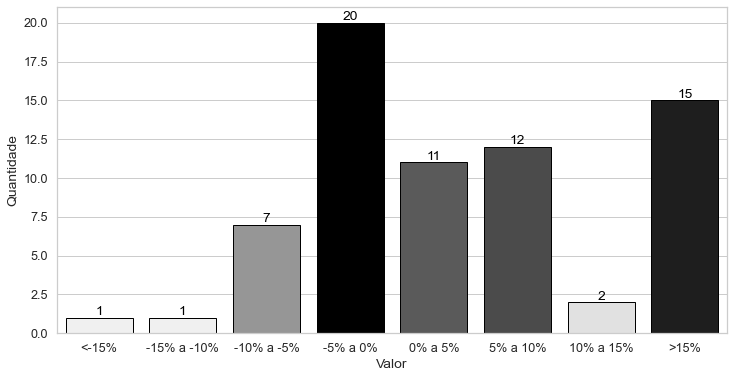

In [51]:
def plot_quantidade_por_rent(DF):
    sns.set(rc={'figure.figsize':(12,6)}, font_scale = 1.15, style='whitegrid')
    plot = sns.barplot(data=DF, x='Valor', y='Quantidade', palette = cm.gist_yarg(DF['Quantidade']*15),ec = 'black')
    for index, row in DF.iterrows():
        plot.text(row.name, row.Quantidade+0.175, round(row.Quantidade,2), color="black", ha="center")

plot_quantidade_por_rent(DF)

## 4.3 Rentabilidade por setor

In [53]:
rent_by_day = hist.pivot_table(values='Adj Close', index='Date', columns='Ticker')

for c in rent_by_day: 
    fixing_close = hist[hist.Ticker == c].reset_index(drop=True).loc[0,'Adj Close']
    rent_by_day[c] = ((rent_by_day[c] / fixing_close) - 1)* 100

rent_by_day_mean = rent_by_day.mean(axis=1)
rent_by_day_mean = pd.DataFrame(data=rent_by_day_mean, columns=['variation'])
rent_by_day_mean = rent_by_day_mean.reset_index()
rent_by_day_mean['Date'] = rent_by_day_mean.apply(lambda x: pd.to_datetime(x.Date,format='%Y-%m-%d',errors='coerce'), axis=1)
rent_by_day_mean = rent_by_day_mean.set_index('Date')

<AxesSubplot:xlabel='1D', ylabel='Setor'>

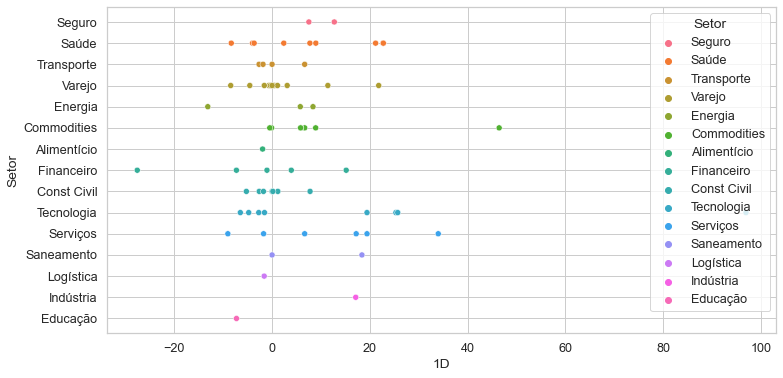

In [54]:
ipo_details['Media_faixa'] = (ipo_details['Min_faixa'] + ipo_details['Max_faixa']) / 2
ipo_details['%Faixa'] = (ipo_details['Preco_fixado'] / ipo_details['Media_faixa']) - 1

rent = rent_df.copy()
details = ipo_details.set_index('Tickers').copy()
correlacao = pd.concat([details, rent], axis =1)
today = rent_by_day.iloc[-1]
correlacao = pd.concat([correlacao, today], axis = 1)
correlacao.columns.values[14] = 'Today'
correlacao = correlacao.drop(columns=['Varejo', 'Institucional', 'Estrangeiros', 'Outros', 'Total_Investidores'])
correlacao

sns.scatterplot(data=correlacao[correlacao.index!='BIDI4'], y='Setor', x='1D', hue='Setor')
#Foi tirado o BIDI4 pois ele é um outlier de rentabilidade muito alta, logo, para melhor visualização foi retirado.

## 4.3 Como se deu o comportamento das rentabilidades e volatilidades (incerteza de movimento) dos IPO's contra o IBOVESPA - índice que retrata a média da bolsa brasileira? 

In [55]:
cota_ibov = cota_ibov.reset_index()
cota_ibov['Date'] = cota_ibov.apply(lambda x: pd.to_datetime(x.Date,format='%Y-%m-%d',errors='coerce'), axis=1)
cota_ibov = cota_ibov.set_index("Date")
ipo_ibov = pd.concat([ rent_by_day_mean, cota_ibov], axis = 1)

In [56]:
def mm(dias,data,i):
    data = data.iloc[i-dias:i]
    return data.variation.mean()

Regressao Linear

In [57]:
rent_mm = rent_by_day_mean.copy()
rent_mm = rent_mm.reset_index()
rent_mm['indice'] = list(rent_mm.index)
rent_mm['media_movel_200'] = rent_mm.apply(lambda x: mm(200,rent_mm,x.indice), axis = 1)
rent_mm['media_movel_100'] = rent_mm.apply(lambda x: mm(100,rent_mm,x.indice), axis = 1)
rent_lr = rent_mm.copy()
rent_lr = rent_lr.dropna().reset_index(drop=True)

In [58]:
result = linregress(rent_lr['indice'], rent_lr['media_movel_200'])
x = result.slope
y = result.intercept
print(f'{x}x + {y}')

0.07019930019922731x + -35.83859442756329


In [59]:
lista_x = list(rent_lr['indice'])
lista_y = []

for i in lista_x:
    lista_y.append(i*result.slope + result.intercept)

x = dict(zip(rent_lr.indice, lista_y))
linr= pd.DataFrame.from_dict(x, orient='index').rename(columns={0:'lin_regress'})
linr = linr.reset_index().rename(columns={'index': 'indice'})
rent_mm = pd.merge(rent_mm, linr, how='outer', on= 'indice')
rent_mm

,Date,variation,indice,media_movel_200,media_movel_100,lin_regress
0,2015-06-05,0.000000,0,NaN,NaN,NaN
1,2015-06-08,-0.863337,1,NaN,NaN,NaN
2,2015-06-09,-1.798566,2,NaN,NaN,NaN
3,2015-06-10,0.719420,3,NaN,NaN,NaN
4,2015-06-11,2.589922,4,NaN,NaN,NaN
...,...,...,...,...,...,...
1503,2021-06-29,77.034298,1503,54.032447,60.244022,69.670954
1504,2021-06-30,79.312502,1504,54.120177,60.282836,69.741153
1505,2021-07-01,77.555949,1505,54.204146,60.303385,69.811352
1506,2021-07-02,80.673752,1506,54.318248,60.258526,69.881552


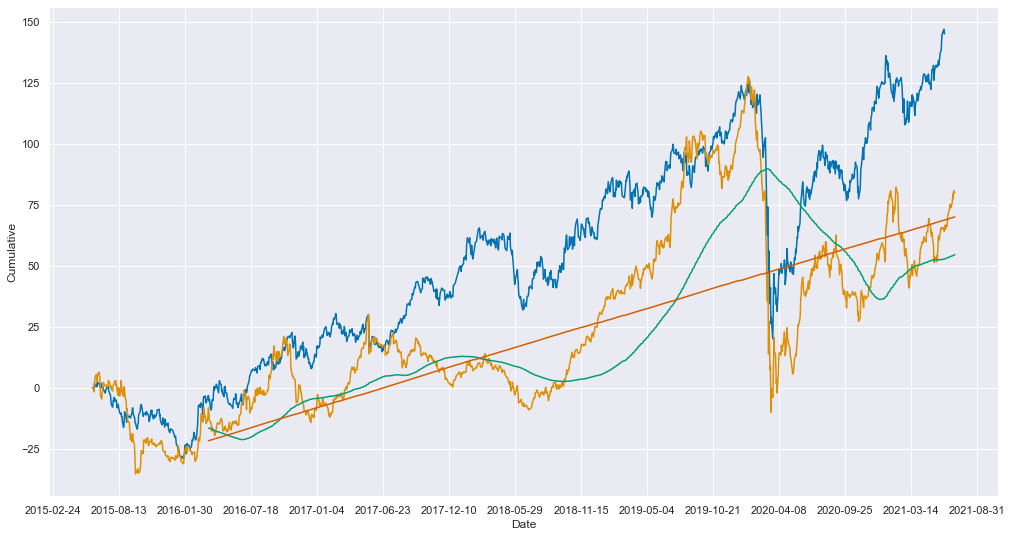

In [60]:
sns.set(rc={'figure.figsize':(17,9)})
sns.set_palette('colorblind')
loc = plticker.MultipleLocator(base=170.0)
axes = sns.lineplot( data=cota_ibov, x='Date', y='Cumulative')
axes2 = sns.lineplot(data=rent_by_day_mean, x = 'Date', y='variation')
axes3 = sns.lineplot(data=rent_mm, x='Date', y='media_movel_200')
axes4 = sns.lineplot(data=rent_mm, x='Date', y='lin_regress')
axes.xaxis.set_major_locator(loc)

In [61]:
ibov = cota_ibov.reset_index().copy()
variation = ipo_df.copy()
variation['var'] = variation.apply(lambda x: (x.preult - x.preabe)/x.preabe, axis = 1)

ibov['vol_media_diaria'] = 0
ibov['vol_media_anual'] = 0
ibov['codneg'] = 'ibov'

variation['vol_media_diaria'] = 0
variation['vol_media_anual'] = 0

ibov['indice'] = list(ibov.index)

variation['indice'] = list(variation.index)

def vol_ant(data, ativo):
    data = data[data.codneg == ativo]
    abertura = dict_tickers[ativo]

    if data.index.max() == 0:
        vol = np.array([data['var'][0], (data['preabe'][0] - abertura)/abertura]).std()  
        return vol
    else:
        vol = data['var'].std()
        return vol
    
def vol_ant_ibov(data, ativo):
    data = data[data.codneg == ativo]
    vol = data['Var%'].std()
    return vol

In [62]:
ibov['vol_media_diaria'] = ibov.apply(lambda x: vol_ant_ibov(ibov[:x['indice']+1],'ibov' ), axis = 1)
ibov = ibov.drop(columns='indice')
ibov['vol_media_anual'] = ibov['vol_media_diaria']*(252**(1/2))
ibov

,Date,index,Último,Var%,Cumulative,vol_media_diaria,vol_media_anual,codneg
0,2015-06-05,0,52973.37,-1.03,0.000000,NaN,NaN,ibov
1,2015-06-08,1,52809.63,-0.31,-0.309099,0.509117,8.081980,ibov
2,2015-06-09,2,52815.99,0.01,-0.297093,0.532666,8.455815,ibov
3,2015-06-10,3,53876.44,2.01,1.704762,1.301486,20.660455,ibov
4,2015-06-11,4,53688.51,-0.35,1.349999,1.150861,18.269345,ibov
...,...,...,...,...,...,...,...,...
1481,2021-06-02,1481,129601.44,1.04,144.653946,1.708187,27.116630,ibov
1482,2021-06-04,1482,130125.78,0.40,145.643764,1.707632,27.107812,ibov
1483,2021-06-07,1483,130776.27,0.50,146.871721,1.707092,27.099238,ibov
1484,2021-06-08,1484,129787.11,-0.76,145.004443,1.706654,27.092289,ibov


In [63]:
variation['vol_media_diaria'] = variation.apply(lambda x: vol_ant(variation[:x['indice']+1],x.codneg ), axis = 1)
variation = variation.drop(columns='indice')
variation['vol_media_anual'] = variation['vol_media_diaria']*(252**(1/2))
variation

,date,codneg,preabe,preult,var,vol_media_diaria,vol_media_anual
0,2015-06-05,WIZS3,13.60,13.90,0.022059,0.040471,0.642457
1,2015-06-08,WIZS3,14.11,13.78,-0.023388,0.032136,0.510136
2,2015-06-09,WIZS3,13.78,13.65,-0.009434,0.023280,0.369566
3,2015-06-10,WIZS3,13.70,14.00,0.021898,0.022884,0.363279
4,2015-06-11,WIZS3,14.01,14.26,0.017844,0.020932,0.332281
...,...,...,...,...,...,...,...
22518,2021-06-09,TFCO4,13.45,13.45,0.000000,0.027733,0.440245
22519,2021-06-09,VAMO3,52.41,51.96,-0.008586,0.026448,0.419845
22520,2021-06-09,VIVA3,31.37,31.66,0.009245,0.039168,0.621774
22521,2021-06-09,WEST3,8.83,8.77,-0.006795,0.039820,0.632130


In [64]:
var_by_day = variation.pivot_table(values='vol_media_anual', index= 'date', columns='codneg')
var_by_day_mean = var_by_day.mean(axis = 1)
var_by_day_mean = pd.DataFrame(data=var_by_day_mean, columns=['media_volatilidade'])
var_by_day_mean = var_by_day_mean.reset_index(drop=False)

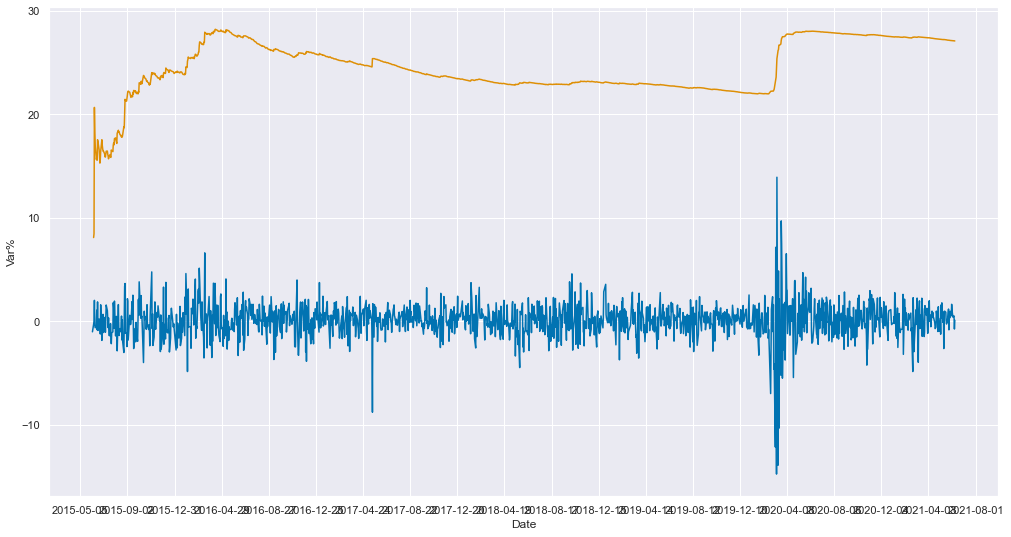

In [65]:
sns.set(rc={'figure.figsize':(17,9)})
sns.set_palette('colorblind')
loc = plticker.MultipleLocator(base=120.0)
axes = sns.lineplot( data=ibov, x='Date', y='Var%')
axes2 = sns.lineplot( data=ibov, x='Date', y='vol_media_anual')
axes.xaxis.set_major_locator(loc)

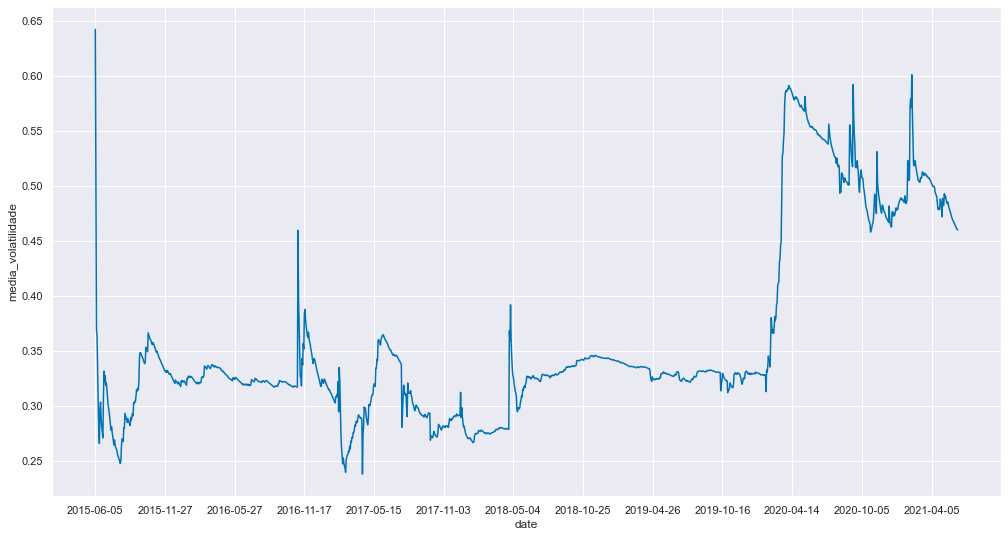

In [66]:
sns.set(rc={'figure.figsize':(17,9)})
sns.set_palette('colorblind')
loc = plticker.MultipleLocator(base=120.0)
axes = sns.lineplot( data=var_by_day_mean, x='date', y='media_volatilidade')
axes.xaxis.set_major_locator(loc)

## 4.4 Existe correlação entre rentabilidade alta e outra variável que não seja bons fundamentos da empresa, ou seja, puramente especulação?

In [67]:
correlacao

,Preco_fixado,Volume,Min_faixa,Max_faixa,Setor,Media_faixa,%Faixa,1D,15D,Today
WIZS3,12.33,6.028000e+08,11.25,11.60,Seguro,11.425,0.079212,12.733171,18.410381,90.715435
AALR3,20.00,6.741976e+08,19.00,22.00,Saúde,20.500,-0.024390,-4.000000,-23.750000,-37.549431
MOVI3,7.50,6.000838e+08,7.50,8.90,Transporte,8.200,-0.085366,-2.666667,-1.333333,153.495089
PARD3,19.00,8.776688e+08,18.71,22.71,Saúde,20.710,-0.082569,8.947368,5.526316,11.029379
AZUL4,21.00,2.021037e+09,19.00,23.00,Transporte,21.000,0.000000,6.666667,14.000000,98.571430
...,...,...,...,...,...,...,...,...,...,...
GGPS3,12.00,2.164502e+09,13.00,15.50,Serviços,14.250,-0.157895,6.666667,1.666667,27.731086
SOJA3,9.90,4.000000e+08,9.90,12.60,Commodities,11.250,-0.120000,46.464646,52.020202,-6.234575
CXSE3,9.67,4.351500e+09,9.33,12.67,Financeiro,11.000,-0.120909,3.929679,20.475698,22.877122
MODL11,20.01,3.064532e+09,24.30,32.82,Financeiro,28.560,-0.299370,-7.296352,-10.044978,2.028723


In [68]:
covid = covid_df.copy()

In [69]:
covid

,regiao,data,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,media_movel_14
0,Brasil,2020-02-25,0.0,0,0,0,NaN
1,Brasil,2020-02-26,1.0,1,0,0,NaN
2,Brasil,2020-02-27,1.0,0,0,0,NaN
3,Brasil,2020-02-28,1.0,0,0,0,NaN
4,Brasil,2020-02-29,2.0,1,0,0,NaN
...,...,...,...,...,...,...,...
472,Brasil,2021-06-09,17122877.0,85748,479515,2723,1768.642857
473,Brasil,2021-06-10,17210969.0,88092,482019,2504,1791.857143
474,Brasil,2021-06-11,17296118.0,85149,484235,2216,1810.357143
475,Brasil,2021-06-12,17374818.0,78700,486272,2037,1799.285714


In [70]:
ibov

,Date,index,Último,Var%,Cumulative,vol_media_diaria,vol_media_anual,codneg
0,2015-06-05,0,52973.37,-1.03,0.000000,NaN,NaN,ibov
1,2015-06-08,1,52809.63,-0.31,-0.309099,0.509117,8.081980,ibov
2,2015-06-09,2,52815.99,0.01,-0.297093,0.532666,8.455815,ibov
3,2015-06-10,3,53876.44,2.01,1.704762,1.301486,20.660455,ibov
4,2015-06-11,4,53688.51,-0.35,1.349999,1.150861,18.269345,ibov
...,...,...,...,...,...,...,...,...
1481,2021-06-02,1481,129601.44,1.04,144.653946,1.708187,27.116630,ibov
1482,2021-06-04,1482,130125.78,0.40,145.643764,1.707632,27.107812,ibov
1483,2021-06-07,1483,130776.27,0.50,146.871721,1.707092,27.099238,ibov
1484,2021-06-08,1484,129787.11,-0.76,145.004443,1.706654,27.092289,ibov


In [71]:
tristeza = ibov.copy()
tristeza = tristeza[ibov.Date >= '2021-01-01']
tristeza = tristeza.reset_index(drop=True)
tristeza = tristeza.rename(columns={'Date': 'data'})
tristeza

,data,index,Último,Var%,Cumulative,vol_media_diaria,vol_media_anual,codneg
0,2021-01-04,1379,118854.71,-0.14,124.366904,1.731321,27.483877,ibov
1,2021-01-05,1380,119376.21,0.44,125.351361,1.730722,27.474364,ibov
2,2021-01-06,1381,119100.08,-0.23,124.830099,1.730115,27.464721,ibov
3,2021-01-07,1382,122385.92,2.76,131.032913,1.730997,27.478730,ibov
4,2021-01-08,1383,125076.63,2.20,136.112277,1.731314,27.483756,ibov
...,...,...,...,...,...,...,...,...
102,2021-06-02,1481,129601.44,1.04,144.653946,1.708187,27.116630,ibov
103,2021-06-04,1482,130125.78,0.40,145.643764,1.707632,27.107812,ibov
104,2021-06-07,1483,130776.27,0.50,146.871721,1.707092,27.099238,ibov
105,2021-06-08,1484,129787.11,-0.76,145.004443,1.706654,27.092289,ibov


In [72]:
desgraca = var_by_day_mean.copy()
desgraca = desgraca[desgraca.index >= '2020-01-01']
desgraca = desgraca.reset_index()
desgraca = desgraca.rename(columns={'date': 'data'})
desgraca

TypeError: Invalid comparison between dtype=int64 and str_

In [73]:
derrota = pd.merge(desgraca, covid, how='inner', on= 'data')
derrota[100:150]

KeyError: 'data'

In [74]:
derrota.corr()

NameError: name 'derrota' is not defined

In [75]:
af = pd.concat([tristeza.set_index('data'), covid[covid.data>='2021-01-01'].set_index('data')],axis=1)
af[100:150]

,index,Último,Var%,Cumulative,vol_media_diaria,vol_media_anual,codneg,regiao,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,media_movel_14
data,,,,,,,,,,,,,
2021-04-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Brasil,13445006.0,71832,351334,2616,2971.857143
2021-04-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Brasil,13482023.0,37017,353137,1803,2913.142857
2021-04-12,1445.0,118811.74,0.97,124.285787,1.722966,27.351238,ibov,Brasil,13517808.0,35785,354617,1480,2923.642857
2021-04-13,1446.0,119297.13,0.41,125.202078,1.722393,27.342147,ibov,Brasil,13599994.0,82186,358425,3808,2910.785714
2021-04-14,1447.0,120294.68,0.84,127.085194,1.721917,27.334583,ibov,Brasil,13673507.0,73513,361884,3459,2912.785714
2021-04-15,1448.0,120700.67,0.34,127.851598,1.721337,27.325373,ibov,Brasil,13746681.0,73174,365444,3560,2883.500000
2021-04-16,1449.0,121113.93,0.34,128.631726,1.720757,27.316172,ibov,Brasil,13832455.0,85774,368749,3305,2868.571429
2021-04-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Brasil,13900091.0,67636,371678,2929,2895.928571
2021-04-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Brasil,13943071.0,42980,373335,1657,2963.214286


In [76]:
af.corr()

,index,Último,Var%,Cumulative,vol_media_diaria,vol_media_anual,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,media_movel_14
index,1.000000,0.423836,0.120502,0.423836,-0.909033,-0.909033,0.998799,0.232346,0.987553,0.499698,0.750466
Último,0.423836,1.000000,0.236647,1.000000,-0.697092,-0.697092,0.453982,-0.120377,0.528011,-0.044848,0.101662
Var%,0.120502,0.236647,1.000000,0.236647,-0.115120,-0.115120,0.122069,0.145315,0.121926,0.103291,0.095538
Cumulative,0.423836,1.000000,0.236647,1.000000,-0.697092,-0.697092,0.453982,-0.120377,0.528011,-0.044848,0.101662
vol_media_diaria,-0.909033,-0.697092,-0.115120,-0.697092,1.000000,1.000000,-0.919788,-0.084099,-0.949992,-0.278324,-0.523299
vol_media_anual,-0.909033,-0.697092,-0.115120,-0.697092,1.000000,1.000000,-0.919788,-0.084099,-0.949992,-0.278324,-0.523299
casosAcumulado,0.998799,0.453982,0.122069,0.453982,-0.919788,-0.919788,1.000000,0.284938,0.993867,0.476316,0.729819
casosNovos,0.232346,-0.120377,0.145315,-0.120377,-0.084099,-0.084099,0.284938,1.000000,0.253315,0.801697,0.300313
obitosAcumulado,0.987553,0.528011,0.121926,0.528011,-0.949992,-0.949992,0.993867,0.253315,1.000000,0.438033,0.698515
obitosNovos,0.499698,-0.044848,0.103291,-0.044848,-0.278324,-0.278324,0.476316,0.801697,0.438033,1.000000,0.696417


<AxesSubplot:xlabel='obitosNovos', ylabel='vol_media_diaria'>

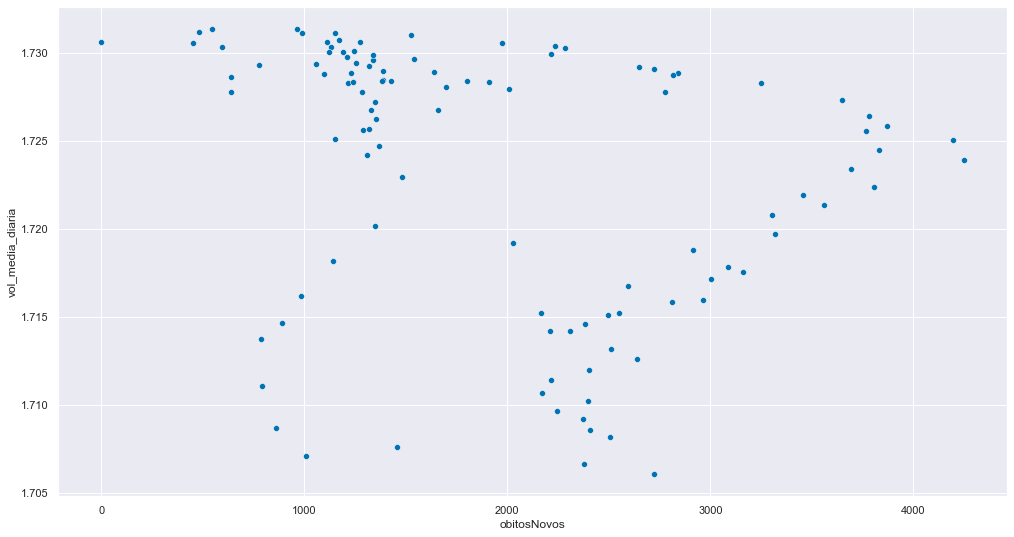

In [77]:
sns.scatterplot(data=af, x='obitosNovos', y='vol_media_diaria')

In [78]:
sns.set(rc={'figure.figsize':(17,9)})
sns.set_palette('colorblind')
loc = plticker.MultipleLocator(base=120.0)
axes = sns.lineplot( data=derrota, x='data', y='media_volatilidade')

axes.xaxis.set_major_locator(loc)

NameError: name 'derrota' is not defined

In [79]:
sns.set(rc={'figure.figsize':(17,9)})
sns.set_palette('colorblind')
loc = plticker.MultipleLocator(base=120.0)
axes = sns.lineplot( data=derrota, x='data', y='media_movel_14')
axes.xaxis.set_major_locator(loc)

NameError: name 'derrota' is not defined

# 5 Conclusão